In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


# Databricks text2sql agent

> Planning agent using instructor library

In [ ]:
#|default_exp agents.dbsqlagent

In [ ]:
#| hide
from nbdev.showdoc import *
from dotenv import load_dotenv
import sys

# Databricks text2sql Agent


Para poder testar este agente, vamos ter que criar uma conta de Databricks e asociarla com um cloud provider. Nosso caso eu fiz com Azure que me da 14 dias de teste, mas pode ser com Amazon ou GCP (não sei as especificações).




## Preparação do ambiente

A primeira coisa a fazer é criar um ambiente e instalar as bibliotecas necesarias. Eu utilizo pipenv para criação do ambiente e instalação das bibliotecas.  Vou deixar o arquivo Pipfile disponivel para instalação das bibliotecas.
```bash
pipenv install
```

Logo depois você pode ativar o ambiente com o comando:
```bash
pipenv shell
```

Para carregar as varaiveis de ambiente, deve criar um arquivo .env na raiz do projeto com as seguintes variaveis:
```bash
SQL_WAREHOUSE_ID=<str>
SQL_INSTANCE=<str:domain>
DATABRICKS_TOKEN=<str>
OPENAI_API_KEY=<str>
```



In [ ]:
#| hide
#| eval:false
sys.path.append('..')
load_dotenv()

True

## Importatr librarias 

In [ ]:
#| exports

from pydantic import Field, model_validator
from langgraph.graph import StateGraph, END, START
from databricks import sql

import pandas as pd
import instructor
from openai import OpenAI
from instructor import OpenAISchema
from typing import Literal, Dict, List, Sequence, TypedDict, Annotated, Any
from langchain_experimental.utilities.python import PythonREPL
from fastcore.basics import patch
import requests
import json
import time
import traceback
import operator
import os
import datetime 

/Users/matu/.local/share/virtualenvs/Agents-uluWm89Z/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clase customizada de mensagens

Para ter um jeito automático de pasar as informações para o LLM, criamos uma clase e os metodos de pasar automaticamente as informações para o LLM.

In [ ]:
# | exports
class Message(OpenAISchema):
    """Class that manage the messages
    Args:
        role (str): role of the message
        content (str): content of the message
        imgs (List[str], optional): list of images. Defaults to [].
    """

    role: str
    content: str
    name: str | None = None
    sql: str | None = None
    plot: str| None = None
    data: List[Dict[Any,Any]] | None = None
    imgs: List[str] = []

    def to_string(self):
        return f"{self.role.upper()}: {self.content}"

    def to_dict(self):
        return {"role": self.role, "content": self.content}
    
    def from_agent(self):
        return {"role": self.role, "content": f"{self.name}: {self.content}"}
    
    def to_api(self):
        # content = self.content if 
        return {
            "role": self.role, 
            "content": self.content,
            "sql": self.sql,
            "plot": self.plot,
            "data": self.data,
            "imgs": self.imgs
        }


class HMessage(Message):
    """Class that manage the User messages
    Args:
        role (str): role of the message
        content (str): content of the message
        imgs (List[str], optional): list of images. Defaults to [].
    """

    role: str = "user"

    def history(self):
        return {"question": self.content}


class SMessage(Message):
    """Class that manage the System messages
    Args:
        role (str): role of the message
        content (str): content of the message
        imgs (List[str], optional): list of images. Defaults to [].
    """

    role: str = "system"


class AMessage(Message):
    """Class that manage the Assistant messages
    Args:
        role (str): role of the message
        content (str): content of the message
        imgs (List[str], optional): list of images. Defaults to [].
    """

    role: str = "assistant"

    def history(self):
        return {"answer": self.content}

In [ ]:
show_doc(Message)

---

### Message

>      Message (role:str, content:str, name:str|None=None, sql:str|None=None,
>               plot:str|None=None, data:Optional[List[Dict[Any,Any]]]=None,
>               imgs:List[str]=[])

*Class that manage the messages
Args:
    role (str): role of the message
    content (str): content of the message
    imgs (List[str], optional): list of images. Defaults to [].*

## Conectando com DataBricks

Para facilitar todo o uso de dataBricks, vamos criar uma clase que carrega as informaçes de conexão e executa as querys no SQL de forma automática. Neste caso não é necesario, mas podemos querer gerar algumas utilidades automaticas no futuro, como embedding das tabelas ou queries tipicas feitas por usuarios, ao encapsular na clase, podemos ir melhorando ainda mais o agente.

In [ ]:
#| exports

class Connection_db(OpenAISchema):
    """Class to connect and execute queries in the SQL Warehouse"""
    server_hostname: str # Databricks server hostname
    http_path: str # Databricks http path
    catalog: str # Databricks catalog
    database: str # Databricks database
    token: str # Databricks token
    cursor: Any # Cursor to execute the queries

    @model_validator(mode='before')
    @classmethod
    def connect(cls, values):
        """Method that validate the conexion and genrate it from the original data"""
        connector = sql.connect(server_hostname=values['server_hostname'], http_path=values['http_path'], catalog=values['catalog'],  access_token=values['token'])
        values['cursor'] = connector.cursor()
        return values


In [ ]:
show_doc(Connection_db)

---

### Connection_db

>      Connection_db (server_hostname:str, http_path:str, catalog:str,
>                     database:str, token:str, cursor:Any)

*Class to connect and execute queries in the SQL Warehouse*

### Metodos para executar as querys

Vamos criar um método para execução da query. Este método recebe a query e retorna o resultado em um dicionario com as colunas e os dados.

In [ ]:

#| exports
@patch
def execute_query(
        self:Connection_db, #self object
        query: str #query to execute
    )-> dict: #Retorna o resultado da query em um dicionario
    """Method that execute the query in the SQL Warehouse
    Args:
        query (str): query to execute
    Returns:
        Dict: dictionary with the result of the query
    """
    response = self.cursor.execute(query)
    data = response.fetchall()
    return self.parse_result(data)


In [ ]:
show_doc(Connection_db.execute_query)

---

### Connection_db.execute_query

>      Connection_db.execute_query (query:str)

*Method that execute the query in the SQL Warehouse
Args:
    query (str): query to execute
Returns:
    Dict: dictionary with the result of the query*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| query | str | query to execute |
| **Returns** | **dict** | **Retorna o resultado da query em um dicionario** |

In [ ]:

#| exportss
@patch
def get_tables(
            self:Connection_db # self object
        ) -> List[str]: # List of tables names
    """Method to list tables available in the database
    Returns:
        List[str]: list of tables names
    """
    query = f"SHOW TABLES in {self.catalog}.{self.database}"
    data = self.execute_query(query)
    tables = data["data"]  # self.parse_result(data)['data']
    return [f"{self.catalog}.{x[0]}.{x[1]}" for x in tables if x[1].find("payload") == -1]


In [ ]:
#| exports
@patch
def get_table_description(
        self:Connection_db, # self object
        table: str # table name
    ) -> Dict[str, str]: # dictionary with table and description
    """Method that returns the table description from Databricks
    Args:
        table (str): table name
    Returns:
        Dict[str, str]: dictionary with table and description
    """
    query = f"DESCRIBE TABLE EXTENDED {table}"
    data = self.execute_query(query)
    df = pd.DataFrame(data['data'], columns = data['columns'])
    cols = self.list_cols(df)
    comment =  df.loc[df['col_name'] == 'Comment']['data_type'].values[0]
    return {"table": table, "description": comment, "columns":cols}  # data #self.parse_result(data)


In [ ]:
show_doc(Connection_db.get_table_description)

In [ ]:


#| exports
@patch
def get_tables_descriptions(
        self:Connection_db, # self object
        tables: list[str] | None = None # list of tables names
    ) -> List[Dict[str, str]]: # list of dictionaries with table and description
    """Function that return the tables and the description
    Args:
        tables (list[str], optional): list of tables. Defaults to None.
    Returns:
        List[Dict[str, str]]: list of dictionaries with table and description
    """
    tables = tables if tables else self.get_tables()
    tables_description = []
    for table in tables:
        table_desc = self.get_table_description(table)
        tables_description.append(table_desc)
    return tables_description


In [ ]:
show_doc(Connection_db.get_tables_descriptions)

In [ ]:

@patch(cls_method=True)
def parse_result(
        cls:Connection_db, # self object
        data: Dict | List # data from the SQL Warehouse
    ) -> Dict[str, Any]: # dictionary with columns and data
    """Class method to parse the result into a dataframe compatible format
    Args:
        data (Dict): data from the SQL Warehouse
    Returns:
        Dict: dictionary with columns and data
    """
    if isinstance(data, dict):
        columns = [x["name"] for x in data["manifest"]["schema"]["columns"]]
        results = data["result"]["data_array"]
    elif isinstance(data, list) and data:
        columns = [x for x in data[0].asDict().keys()]
        results = [list(x.asDict().values()) for x in data]
    return {"columns": columns, "data": results}


In [ ]:
show_doc(Connection_db.parse_result)

In [ ]:

#| exports
@classmethod
@patch
def row_2_str(
        cls:Connection_db,  # self object
        row # row to convert
    ):
    """Method to convert a column from the table description into a string, spcifying the name, type and comment availables
    Args:
        row: row to convert
    Returns:
        str: row as string
    """
    return f"{row[0]} ( {row[1] if row[1] else ''} {row[2] if row[2] else ''})"


In [ ]:
show_doc(Connection_db.row_2_str)

In [ ]:

#| exports
@classmethod
@patch
def list_cols(
        cls:Connection_db, # self object
        df: pd.DataFrame # dataframe with the columns
    ) -> List[str]: # list of columns as string
    """Method to list the columns of a table
    Args:
        df: dataframe with the columns
    Returns:
        List[str]: list of columns as string
    """
    end_i = df.loc[df['col_name'] == ''].index[0]
    cols = df.loc[:end_i-1] #usar i -1
    return cols.apply(lambda row: cls.row_2_str(row), axis=1).to_list()



In [ ]:
show_doc(Connection_db.list_cols)

Agora, vamos gerar uma clase que para encapsular a conexão com o SQL Warehouse e as querys. Esta clase pode ser utilizada com qualquer outra conexão, mas para testar, vamos utilizar a conexão com Databricks.

In [ ]:
# | exports
class GenieWarehouse(OpenAISchema):
    """Class with all information to connect and query the warehouse
    Args:
        catalog (str): catalog name
        connection (Connection): connection to the warehouse
        tables (List[Any], optional): list of tables. Defaults to [].
        tables_description (List, optional): list of tables description. Defaults to [].
        tables_columns (Dict, optional): dictionary with table and columns. Defaults to {}.
    """

    catalog: str # Databricks catalog
    connection:  Connection_db # Connection to the SQL Warehouse
    tables: List[Any] = [] # List of tables names
    tables_data : List = [] # List of tables descriptions


    def get_queries(self):
        """Method to list queries from the warehouse"""
        pass

    def get_tables(self) -> str:
        """Return the tables as string
        Returns:
            str: tables as string"""
        tables_string = "\n".join( [f"<table>{table}</table>" for table in self.tables])        
        return f"<tables>\n{tables_string}\n</tables>"

    def get_tables_description(self) -> str:
        """Method to return the tables description
        Returns:
            str: tables description as string
        """

        results = []
        for table_name in self.tables:
            results.append(self.get_table_description(table_name, self.tables_data))
        string =  "\n".join(results)
        return f"<tables_descriptions>\n{string}\n</tables_descriptions>"

    def dict_2_str(self, data: Dict) -> str:
        """Method to convert a dictionary to string
        Args:
            data (Dict): dictionary
        Returns:
            str: dictionary as string
        """
        return ", ".join([v for k, v in data.items()])

    def get_table_description(self, table: str, tables_data:List) -> str:
        """Method to get the table description
        Args:
            table (str): table name
        Returns:
            str: table description as string
        """
        tables_description = [{x['table']: x['description']} for x in self.tables_data]
        description = [x['description'] for x in self.tables_data if x['table'] == table]
        return f"<description table={table}>{description[0]}</description>" if description else f"<description table={table}>No description</description>"

    def get_tables_columns(self) -> str:
        """Method to return the tables columns
        Returns:
            str: tables columns as string
        """
        # tables_data = self.connection.get_tables_descriptions()
        tables_columns = {x['table']: x['columns'] for x in self.tables_data}
        results = []
        for table_name in self.tables: 
            results.append(self.get_table_columns(tables_columns, table_name))
        string = "\n".join(results)
        return f"<tables_columns>\n{string}\n</tables_columns>"

    def get_table_columns(self, columns: List, table:str) -> str:
        """Method to get the columns of a table
        Args:
            table (str): table name
        Returns:
            str: columns as string
        """
        columns = [x['columns'] for x in self.tables_data  if x['table'] == table]
        strings = [f"<col>{x}</col>" for x in columns[0]]
        return f"<columns table={table}>{''.join(strings)}</columns>"

    def get_db_information(self):
        """ Method that generates an structured tables information"""
        results = []
        for table in self.tables_data:
            string = f"""<table>{table['table']}</table>
            <description>{table['description']}</description>
            <columns>{''.join([f"<col>{x}</col>" for x in table['columns']])}</columns>"""
            results.append(string)
            # results.append(self.get_table_description(table, self.tables_data))
            # results.append(self.get_table_columns(table, self.tables_data))
        return "\n".join(results)

    def execute(self, query: str) -> str | Dict[str, Any]:
        """Method to execute the query
        Args:
            query (str): query to execute
        Returns:
            str| Dict[str, Any]: response of the query
        """
        try:
            response = self.connection.execute_query(query)
        except Exception as e:
            response = f"ERROR: {e}"
        return response

    @classmethod
    def from_catalog(
        cls,
        token: str,
        catalog: str = "cat_holding_ai_dev",
        database: str = "db_llm_genie",
        **kwargs
    ):
        """Class method to create the instance from the catalog
        Args:
            catalog (str, optional): catalog name. 
            database (str, optional): database name. 
            token (str, optional): token. 
        Returns:
            GenieWarehouse: instance of the class
        """
        connection = Connection(token=token, catalog=catalog, database=database, **kwargs)
        tables = connection.get_tables()
        tables_data = connection.get_tables_descriptions()


        return cls(
            catalog=catalog,
            connection=connection,
            tables_data = tables_data,
            tables=tables,
        )
    
    @classmethod
    def from_databricks_sql(
        cls,
        token: str,
        catalog: str = "text2sql",
        database: str = "default",
        server_hostname: str = os.environ.get("SQL_INSTANCE"),
        http_path: str = "/sql/1.0/warehouses/80623503f797f914",
    ):
        connection = Connection_db(server_hostname=server_hostname, http_path=http_path, catalog = catalog, database = database, token=token)
        tables = connection.get_tables()
        tables_data = connection.get_tables_descriptions()

        return cls(
            catalog=catalog,
            connection=connection,
            tables_data = tables_data,
            tables=tables,
        )

In [ ]:
show_doc(GenieWarehouse)

---

### GenieWarehouse

>      GenieWarehouse (catalog:str, connection:__main__.Connection_db,
>                      tables:List[Any]=[], tables_data:List=[])

*Class with all information to connect and query the warehouse
Args:
    catalog (str): catalog name
    connection (Connection): connection to the warehouse
    tables (List[Any], optional): list of tables. Defaults to [].
    tables_description (List, optional): list of tables description. Defaults to [].
    tables_columns (Dict, optional): dictionary with table and columns. Defaults to {}.*

In [ ]:
#| eval:false
connection = GenieWarehouse.from_databricks_sql(token=os.environ.get("DATABRICKS_TOKEN"), server_hostname=os.environ.get("SQL_INSTANCE"), http_path="/sql/1.0/warehouses/80623503f797f914")


/var/folders/4_/_3_qxk816cq05p7xgwhzqmnm0000gn/T/ipykernel_23953/4211861179.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f"{row[0]} ( {row[1] if row[1] else ''} {row[2] if row[2] else ''})"


In [ ]:
#| eval:false
print(connection.get_tables())

<tables>
<table>text2sql.default.imoveis_details</table>
</tables>


In [ ]:
#| eval:false
print(connection.get_tables_description())

<tables_descriptions>
<description table=text2sql.default.imoveis_details>The 'imoveis_details' table contains information about various real estate properties. It includes data such as the unique identifier, type of property, postal code, city, state, approximate location coordinates, radius, street name, neighborhood, price, last update timestamp, IPTU (property tax) information, and condominium fees. The table also indicates whether the location coordinates are approximated or not. This table is significant to the business as it provides detailed information about individual properties, allowing for analysis and decision-making related to real estate investments and market trends.</description>
</tables_descriptions>


In [ ]:
#| eval:false
print(connection.get_tables_columns())

<tables_columns>
<columns table=text2sql.default.imoveis_details><col>_c0 ( int )</col><col>_id ( string )</col><col>kind ( string If it is on sale or rent)</col><col>code ( string the real state code)</col><col>url ( string the url of the announcement)</col><col>item_id ( string the id)</col><col>bairro ( string O bairro onde o imovel esta localizado)</col><col>cidade ( string a cidade)</col><col>estado ( string o estado)</col><col>aproximated ( boolean )</col><col>approximateLat ( double latitude aproximada)</col><col>approximateLon ( double longitude aproximada)</col><col>radius ( double )</col><col>cep ( int )</col><col>rua_slung ( string o nome da rua transformada em unicode e espaços convertidos em _)</col><col>bairro_slung ( string o nome da bairro transformada em unicode e espaços convertidos em _)</col><col>price ( int preço)</col><col>updated ( double )</col><col>iptu ( string )</col><col>condo ( double )</col><col>size ( double )</col><col>rooms ( string )</col><col>garages 

In [ ]:
#| eval:false
print(connection.get_db_information())

<table>text2sql.default.imoveis_details</table>
            <description>The 'imoveis_details' table contains information about various real estate properties. It includes data such as the unique identifier, type of property, postal code, city, state, approximate location coordinates, radius, street name, neighborhood, price, last update timestamp, IPTU (property tax) information, and condominium fees. The table also indicates whether the location coordinates are approximated or not. This table is significant to the business as it provides detailed information about individual properties, allowing for analysis and decision-making related to real estate investments and market trends.</description>
            <columns><col>_c0 ( int )</col><col>_id ( string )</col><col>kind ( string If it is on sale or rent)</col><col>code ( string the real state code)</col><col>url ( string the url of the announcement)</col><col>item_id ( string the id)</col><col>bairro ( string O bairro onde o imovel 

# creating the Tools for the agent.

The tools includes someway to get the tables, the columns for a table, the description of the table, check the sql query, correct the sql querrym

## State declaration

In [ ]:
# | exports
class State(TypedDict):
    """Class that manage the state of the agent
    Args:
        message (Message): message
        history (Sequence[Message]): history of the messages
        next (str): next tool to call
        parameters (Dict[str, Any]): parameters to be used in the next tool
        code (str): code to be executed
        connection (GenieWarehouse): connection to the SQL Warehouse
        dataframe (pd.DataFrame): dataframe to be used in the code
        error (str): error message if the code is not correct
    """

    message: Message # Message to be used in the agent
    history: Annotated[Sequence[Message], operator.add] # History of the messages
    next: str = Field(
        ...,
        description="The next tool to call from the available tools",
        enum=[
            "get_tables",
            "describe_tables",
            "get_columns",
            "write_sql_queries",
            "write_pandas",
            "final_answer",
        ],
    ) # Next tool to call
    code: str = Field(None, description="SQL code to be executed.") # SQL code to be executed
    python: Dict = Field(None, description="Python code to be executed.") # Python code to be executed
    connection: GenieWarehouse = Field(
        ..., description="Connection to the SQL Warehouse"
    ) # Connection to the SQL Warehouse
    dataframe: pd.DataFrame | None = Field(
        None, description="Dataframe to be used in the code."
    ) # Dataframe to be used in the code
    error: str | None = Field(
        None, description="Error message if the code is not correct."
    ) # Error message if the code is not correct
    sql_write_passes: int = Field(0, description="Number of times the SQL query was written and passed.") # Number of times the SQL query was written and passed

In [ ]:
show_doc(State)

---

### State



*Class that manage the state of the agent
Args:
    message (Message): message
    history (Sequence[Message]): history of the messages
    next (str): next tool to call
    parameters (Dict[str, Any]): parameters to be used in the next tool
    code (str): code to be executed
    connection (GenieWarehouse): connection to the SQL Warehouse
    dataframe (pd.DataFrame): dataframe to be used in the code
    error (str): error message if the code is not correct*

## get_tables

In [ ]:
# | exports
def get_tables(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the graph
    """Function to get the tables available
    Args:
        state (State): state of the graph
    Returns:
        Dict: dictionary with the history of the message
    """
    connection = state["connection"]
    tables = connection.get_tables()
    message = f"The available tables are:\n{tables}"
    return {"history": [HMessage(content=message)]}

In [ ]:
show_doc(get_tables)

---

### get_tables

>      get_tables (state:__main__.State)

*Function to get the tables available
Args:
    state (State): state of the graph
Returns:
    Dict: dictionary with the history of the message*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the graph** |

## describe_tables

In [ ]:
# | exports
def describe_tables(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """Function to describe the table
    Args:
        state (State): state of the graph
    Returns:
        Dict: dictionary with the history of the message
    """
    connection = state["connection"]
    table_description = connection.get_tables_description()
    message = f"Below are the tables and its descrpition:\n{table_description}"
    return {"history": [HMessage(content=message)]}

In [ ]:
show_doc(describe_tables)

---

### describe_tables

>      describe_tables (state:__main__.State)

*Function to describe the table
Args:
    state (State): state of the graph
Returns:
    Dict: dictionary with the history of the message*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

## get_columns

In [ ]:
# | exports
def get_columns(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """Function to get the columns
    Args:
        state (State): state of the graph
    Returns:
        Dict: dictionary with the history of the message
    """
    connection = state["connection"]
    columns = connection.get_tables_columns()
    message = f"The tables at they columns are:\n{columns}"
    return {"history": [HMessage(content=message)]}

In [ ]:
show_doc(get_columns)

---

### get_columns

>      get_columns (state:__main__.State)

*Function to get the columns
Args:
    state (State): state of the graph
Returns:
    Dict: dictionary with the history of the message*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

## check_sql_query

In [ ]:
# | exports
def check_sql_query(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """Function to check the SQL query
    Args:
        state (State): state of the graph
    Returns:
        Dict: dictionary with the history of the message
    """
    connection = state["connection"]
    query = state["code"]
    try:
        response = connection.execute(query)
        if not 'data' in response:
            message = f"The SQL query ```sql {state['code']}``` did not returned any data, Try again."
            error = ""
            next = 'write_sql_queries' if state['sql_write_passes'] < 4 else 'final_answer'
            df = None
        else:
            error = ""
            df = pd.DataFrame(response["data"], columns=response["columns"])
            df = df.apply(pd.to_numeric, errors='ignore')
            message = f"The SQL query ```sql {state['code']}``` returned:\n{df.head(50).to_csv()}"
            next = 'router'
    except Exception as e:
        error = traceback.format_exc()
        message = f"The SQL query was wrong and returned the error:\n{e}\nTraceback:\n{error}"
        df = None
        next = 'write_sql_queries'
    return {"history": [HMessage(content=message)], "dataframe": df, "error": error, 'next':next, "sql_write_passes": state["sql_write_passes"] + 1}

In [ ]:
show_doc(check_sql_query)

---

### check_sql_query

>      check_sql_query (state:__main__.State)

*Function to check the SQL query
Args:
    state (State): state of the graph
Returns:
    Dict: dictionary with the history of the message*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

## Pandas class

In [ ]:
# | exports
class Pandas_code(OpenAISchema):
    """Class that represnts the code to generate graph in pandas"""

    code: str = Field(
        ...,
        description="Correctly wrote Python code to plot the dataframe using plotly library.",
    ) # Python code to plot the dataframe using plotly library
    imports: str = Field(..., description="Imports needed for the code.") # Imports needed for the code
    error: str | None = Field(
        None, description="Error message if the code is not correct."
    ) # Error message if the code is not correct
    returns: Any | None = Field(
        None, description="Returns the figure data after execution."
    ) # Returns the figure data after execution

    def execute(
            self, # self object
            data: pd.DataFrame # dataframe to be used in the code
        ) -> None: # None
        """method to execute the action item"""
        python = PythonREPL(_globals={"df":data, "fig":None}, )
        # python
        if self.code:
            try:
                code = clean_code(self.code)
                print(f"Code to run: {code}\n\n")
                printed = python.run(code) # + "\n\n" + "print(fig.to_json())") #"\n" + "globals()['fig'] = fig" + 
                self.returns = json.loads(printed)
                print(f"{self.returns}")
                # self.returns = python.globals["fig"].to_json()
                if not self.returns:
                    raise Exception("ERROR: The code does not returned the figure")
            except Exception as e:
                self.error = f"ERROR: {e}\n{traceback.format_exc()}"
                raise Exception(f"ERROR: {e}\nTraceback: {traceback.format_exc()}")
        return
    


In [ ]:
show_doc(Pandas_code)

---

### Pandas_code

>      Pandas_code (code:str, imports:str, error:str|None=None,
>                   returns:typing.Any|None=None)

*Class that represnts the code to generate graph in pandas*

In [ ]:
def clean_code(
        code: str, # code to be cleaned
        ) -> str: # cleaned code
    """Function to clean code and modify it to return the json text"""
    lines = code.split('\n')
    filter_lines = [line for line in lines if not line.endswith('show()')]
    filter_lines.append('print(fig.to_json())')
    return "\n".join(filter_lines)



In [ ]:
#| eval:false
show_doc(clean_code)

---

### clean_code

>      clean_code (code:str)

*Function to clean code and modify it to return the json text*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| code | str | code to be cleaned |
| **Returns** | **str** | **cleaned code** |

## check_pandas

In [ ]:
# | exports
def check_pandas(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """Node taht checks the panda code and execute it
    Args:
        state (State): state of the graph
    Returns:
        Dict: dictionary with the history of the message
    """
    code = Pandas_code(**state["python"])
    try:
        _ = code.execute(state["dataframe"])
        next = 'final_answer'
        code = code
        message = "The plot was genearted successfully"
    except Exception as e:
        next = 'write_pandas'
        code = code
        error = code.error
        message = f"The code:{code}\n was wrong and returned the error:\n{e}\nTraceback:\n{error}"
    return {"python": code, "next": next, "error": code.error, "history": [HMessage(content=message)]}

In [ ]:
show_doc(check_pandas)

---

### check_pandas

>      check_pandas (state:__main__.State)

*Node taht checks the panda code and execute it
Args:
    state (State): state of the graph
Returns:
    Dict: dictionary with the history of the message*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

## client

Neste exemplo, estamos usando tudo com openAI e especialemente a libraria Instructor, que tem a vantagem de transformar todo o output do LLM (string) em um objeto com estrutura definida.

In [ ]:
# | exports
#| eval:false
llm_model = "gpt-4o-mini"

client = instructor.from_openai(
    OpenAI(
        api_key=os.environ.get("OPENAI_API_KEY"),
    ),
)

## SQL prompts

In [ ]:
# | exports
SQL_PREFIX = f"""You are an agent designed to interact with a SQL database from DataBricks.
Given an input question, create a syntactically correct SQL query to run. Always use the tables and columns that are available in the database.
As these is a database from scrapped information, the data is of varied formats, always try to use regular expressions or loosy matches.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
Always return the end result ordered by the most relevant column.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
Today is {datetime.date.today().strftime("%B %d, %Y")}.
"""

SQL_FUNCTIONS_SUFFIX = """I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables."""


## Router Prompts

In [ ]:
#| exports
ROUTER_PREFIX = """Think step by step and plan each step to gather the information required to succesfully answer the user's question.

You have some tools to interact with the database:
- Get the tables available in the database use 'get_tables' tool.
- Describe a table in the database. 'describe_tables' tool.
- Get the columns of a table in the database. 'get_columns' tool.
- Generate and check a SQL query in the database. 'write_sql_queries' tool.
- Generate a python code to generate an engaging graph. 'write_pandas' tool.

When you have the information needed, answer the user using the tool 'final_answer'
"""

## Router class

In [ ]:
# | exports
class Router(OpenAISchema):
    """Class to route the messages"""

    next: str = Field(
        ...,
        description="The next tool to call from the available tools",
        enum=[
            "get_tables",
            "describe_tables",
            "get_columns",
            "write_sql_queries",
            "write_pandas",
            "final_answer",
        ],
    )

In [ ]:
# | exports
def router(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """
    Router to guide the agent
    """
    data: Router = client.chat.completions.create(
        model=llm_model,
        response_model=Router,
        messages=[
            {"role": "system", "content": ROUTER_PREFIX},
            state["message"].to_dict(),
            *[x.to_dict() for x in state["history"]],
        ],
    )
    print(data.next)
    return {"next": data.next}

In [ ]:
show_doc(router)

---

### router

>      router (state:__main__.State)

*Router to guide the agent*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

## SQL interpreter

In [ ]:
# | exports
class Code_interpreter(OpenAISchema):
    """Class that represnts the code interpreter strucuter"""

    code: str = Field(
        ...,
        description="Correctly wrote SQL query to retrieve the data needed by the agent.",
    )
    error: str | None = Field(
        None, description="Error message if the code is not correct."
    )

## write_sql

In [ ]:
# | exports
def write_sql(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """code_generation: Code_interpreter = Field(None, description="Code interpreter for the agent.")
    answer: str = Field(None, description="Answer from the agent.")
    next: str = Field(None, description="Next step for the agent.")
    """
    data: Code_interpreter = client.chat.completions.create(
        model=llm_model,
        response_model=Code_interpreter,
        messages=[
            {"role": "system", "content": SQL_PREFIX},
            state["message"].to_dict(),
            *[x.to_dict() for x in state["history"]],
        ],
    )
    code = data.code.strip(";")
    print(code)
    return {"code": code, 'history': [HMessage(content=code)]}    

In [ ]:
show_doc(write_sql)

---

### write_sql

>      write_sql (state:__main__.State)

*code_generation: Code_interpreter = Field(None, description="Code interpreter for the agent.")
answer: str = Field(None, description="Answer from the agent.")
next: str = Field(None, description="Next step for the agent.")*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

## Pandas plotting agent

In [ ]:
# | exports
def write_pandas(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """Function that generates the python code to plot the dataframe using plotly library"""
    data: Pandas_code = client.chat.completions.create(
        model=llm_model,
        response_model=Pandas_code,
        messages=[
            {
                "role": "system",
                "content": """You are an experienced data analyst, and you will generate the correct python code to graphically presents the data with the library 'plotly'.
                Before start, think step by step on the best and most engaging graph to answer the user question with the avaialble data, double check the code. All the titles, labels, legends, and text MUST be written Brazilian portuguese.
                """,
            },
            state["message"].to_dict(),
            {
                "role": "user",
                "content": f"""Given the following dataframe 'df', create an engaging plot to answer the user's question.
                Separate the code by imports and code.
                When you ran the command '''python 
                  df.head(3)
                  ''' 
                  you got:
                  {state['dataframe'].head(3)}.

                  Never show the plot, just assign it to the variable 'fig'.
                  """,
            },
            {
                "role":"user",
                "content":"All the titles, labels, legends, and text MUST be written Brazilian portuguese"
            }
        ],
    )
    return {"python": data.model_dump(), 'history': [HMessage(content=data.code)]}

In [ ]:
show_doc(write_pandas)

---

### write_pandas

>      write_pandas (state:__main__.State)

*Function that generates the python code to plot the dataframe using plotly library*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

In [ ]:
# | exports
class FinalAnswer(OpenAISchema):
    """The final answer to the user"""

    answer: str = Field(
        ...,
        description="A detailed and explanatory final answer based on the question and the data.",
    )

## final_answer

In [ ]:
# | exports
def final_answer(
        state: State # state of the graph
        ) -> State: # dictionary with the state of the message
    """
    Generate the final answer to user's question
    """
    if isinstance(state["dataframe"], pd.DataFrame):
        agent_messages = [
            {"role": "user", "content": f"Here is the data you requested:\n{state['dataframe'].head(20)}"},
            state["history"][-1].to_dict()
        ]
    else:
        agent_messages = [
            *[x.to_dict() for x in state["history"]],
            {"role": "user", "content": f"Be conversational, and guide me to ask about data or ask for clarification"},
        ]
    data: FinalAnswer = client.chat.completions.create(
        model=llm_model,
        response_model=FinalAnswer,
        messages=[
            {
                "role": "system",
                "content": f"""Your name is GAB Lakehouse, and you are a senior Data Analyst that assist the user to answer all his question about data, in a detailed and explanatory way.
                Today is {datetime.date.today().strftime("%B %d, %Y")}.
""",
            },
            state["message"].to_dict(),
            *agent_messages,
            {"role": "user", "content": "Always answer in Portugues from Brazil"},
        ],
    )
    message = data.answer
    state["message"] = AMessage(content=message)
    print(message)
    return state

In [ ]:
show_doc(final_answer)

---

### final_answer

>      final_answer (state:__main__.State)

*Generate the final answer to user's question*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| state | State | state of the graph |
| **Returns** | **State** | **dictionary with the state of the message** |

# starting the graph

## Creation of the Graph

In [ ]:
# | exports

graph = StateGraph(State)
tools = [
    "get_tables",
    "describe_tables",
    "get_columns",
    "write_sql_queries",
    "write_pandas",
    "final_answer",
]
graph.add_node("get_tables", get_tables)
graph.add_node("get_columns", get_columns)
graph.add_node("describe_tables", describe_tables)
graph.add_node("check_sql_query", check_sql_query)
graph.add_node("write_sql_queries", write_sql)
graph.add_node("final_answer", final_answer)
graph.add_node("write_pandas", write_pandas)
graph.add_node("check_pandas", check_pandas)

graph.add_node("router", router)

graph.set_entry_point("router")

graph.add_edge("get_tables", "router")
graph.add_edge("get_columns", "router")
graph.add_edge("describe_tables", "router")
graph.add_edge("write_sql_queries", "check_sql_query")
# graph.add_edge("check_sql_query", "router")
graph.add_edge("write_pandas", "check_pandas")
graph.add_edge("final_answer", END)


def should_continue(state):
    """ """
    return state["next"]


graph.add_conditional_edges("router", should_continue, {v: v for v in tools})
graph.add_conditional_edges(
    "check_pandas",
    should_continue,
    {"write_pandas": "write_pandas", "final_answer": "final_answer"},
)
graph.add_conditional_edges(
    "check_sql_query",
    should_continue,
    {"write_sql_queries": "write_sql_queries", "router": "router", "final_answer": "final_answer"},
)
app = graph.compile()
    # return app

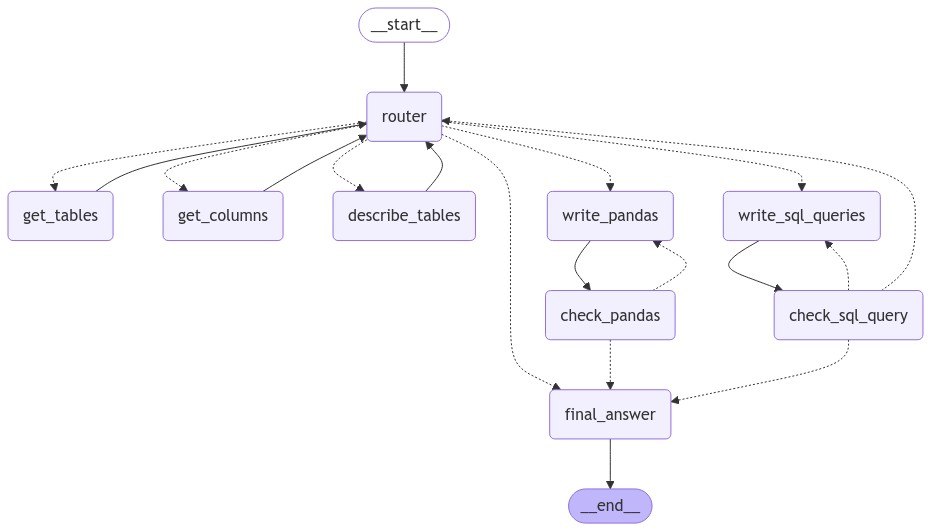

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
#| eval:false
state = State(
    connection=connection,
    message=HMessage(content="Qual é a estatistica de valor de venda de imoveis dependendo do numero de quartos? grafica o resultado"),
    history=[],
    sql_write_passes=0,
)

In [ ]:
#| eval:false  
for s in app.stream(state):
    print(s)
    print("-" * 100)

get_tables
{'router': {'next': 'get_tables'}}
----------------------------------------------------------------------------------------------------
{'get_tables': {'history': [HMessage(role='user', content='The available tables are:\n<tables>\n<table>text2sql.default.imoveis_details</table>\n</tables>', name=None, sql=None, plot=None, data=None, imgs=[])]}}
----------------------------------------------------------------------------------------------------
describe_tables
{'router': {'next': 'describe_tables'}}
----------------------------------------------------------------------------------------------------
{'describe_tables': {'history': [HMessage(role='user', content="Below are the tables and its descrpition:\n<tables_descriptions>\n<description table=text2sql.default.imoveis_details>The 'imoveis_details' table contains information about various real estate properties. It includes data such as the unique identifier, type of property, postal code, city, state, approximate location c

/var/folders/4_/_3_qxk816cq05p7xgwhzqmnm0000gn/T/ipykernel_23953/816601046.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


{'check_sql_query': {'history': [HMessage(role='user', content='The SQL query ```sql SELECT rooms, AVG(price) AS average_price \nFROM text2sql.default.imoveis_details \nWHERE kind IS NOT NULL \nGROUP BY rooms \nORDER BY average_price DESC``` returned:\n,rooms,average_price\n0,5,5366666.666666667\n1,False,3000000.0\n2,0,2904468.8421052634\n3,4,2380882.3529411764\n4,3,934993.3333333334\n5,,840000.0\n6,2,504815.9259259259\n7,1,345000.0\n', name=None, sql=None, plot=None, data=None, imgs=[])], 'next': 'router', 'dataframe':    rooms  average_price
0      5   5.366667e+06
1  False   3.000000e+06
2      0   2.904469e+06
3      4   2.380882e+06
4      3   9.349933e+05
5   None   8.400000e+05
6      2   5.048159e+05
7      1   3.450000e+05, 'error': '', 'sql_write_passes': 4}}
----------------------------------------------------------------------------------------------------
write_pandas
{'router': {'next': 'write_pandas'}}
---------------------------------------------------------------------

Python REPL can execute arbitrary code. Use with caution.


{'write_pandas': {'history': [HMessage(role='user', content="import plotly.express as px\n\nfig = px.bar(df, x='rooms', y='average_price',\n             title='Valor Médio de Venda de Imóveis por Número de Quartos',\n             labels={'rooms': 'Número de Quartos', 'average_price': 'Valor Médio de Venda'},\n             color='average_price',\n             text='average_price')\nfig.update_traces(texttemplate='%{text:.2f}', textposition='outside')\nfig.update_layout(yaxis_title='Valor Médio de Venda',\n                  xaxis_title='Número de Quartos',\n                  legend_title='Valor Médio de Venda')", name=None, sql=None, plot=None, data=None, imgs=[])], 'python': {'code': "import plotly.express as px\n\nfig = px.bar(df, x='rooms', y='average_price',\n             title='Valor Médio de Venda de Imóveis por Número de Quartos',\n             labels={'rooms': 'Número de Quartos', 'average_price': 'Valor Médio de Venda'},\n             color='average_price',\n             text='a

In [ ]:
#| eval:false

print(s["final_answer"]['message'].to_string())


ASSISTANT: A análise dos dados de valor de venda de imóveis em relação ao número de quartos nos fornece uma perspectiva clara sobre como o número de quartos influencia o preço médio dos imóveis. 

Aqui está uma visão geral dos dados:  
- **5 quartos**: média de R$ 5.366.667  
- **4 quartos**: média de R$ 2.380.882  
- **3 quartos**: média de R$ 934.993  
- **2 quartos**: média de R$ 504.816  
- **1 quarto**: média de R$ 345.000  
- **0 quartos**: média de R$ 2.904.469  
- **Falso (provavelmente dados ausentes ou inválidos)**: média de R$ 3.000.000  
- **None (dados ausentes)**: média de R$ 840.000  

Como podemos observar, conforme o número de quartos aumenta, o preço médio dos imóveis também tende a aumentar significativamente. Os imóveis com 5 quartos têm o maior preço médio, quase 6 vezes mais do que aqueles com 1 quarto. Por outro lado, imóveis classificados com 0 quartos ou dados ausentes, apesar de apresentarem valores altos, podem não representar adequadamente a realidade do mer

In [ ]:
#| eval:false
s["final_answer"]["dataframe"]

,rooms,average_price
0,5,5.366667e+06
1,False,3.000000e+06
2,0,2.904469e+06
3,4,2.380882e+06
4,3,9.349933e+05
5,None,8.400000e+05
6,2,5.048159e+05
7,1,3.450000e+05


In [ ]:
#| eval:false
import plotly.io as pio
import json


In [ ]:
#| eval:false
pio.from_json(json.dumps(s["final_answer"]["python"].returns))



In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()